# アミノ酸配列のグラフ表示画像のTransformerによるタンパク質ファミリー分類（5分割交差検証）
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$10$
    - 学習率：$5 \times 10^{-4}$

## 1. ライブラリのインポート

In [1]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTImageProcessorFast, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [2]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [3]:
processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224-in21k")
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [4]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../gpcr_labels.csv", "../graphs/gradation", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_42832\2519183159.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.807238,0.687176,0.559765
2,0.804100,0.776601,0.715026,0.622047
3,0.799800,0.766434,0.720855,0.645559
4,0.751100,0.710829,0.748705,0.710710
5,0.751100,0.675214,0.776554,0.734327
6,0.691800,0.623006,0.793394,0.751299
7,0.639700,0.559290,0.813472,0.785551
8,0.535900,0.524297,0.824482,0.793844
9,0.535900,0.494672,0.843264,0.833794
10,0.453200,0.466433,0.851684,0.838879


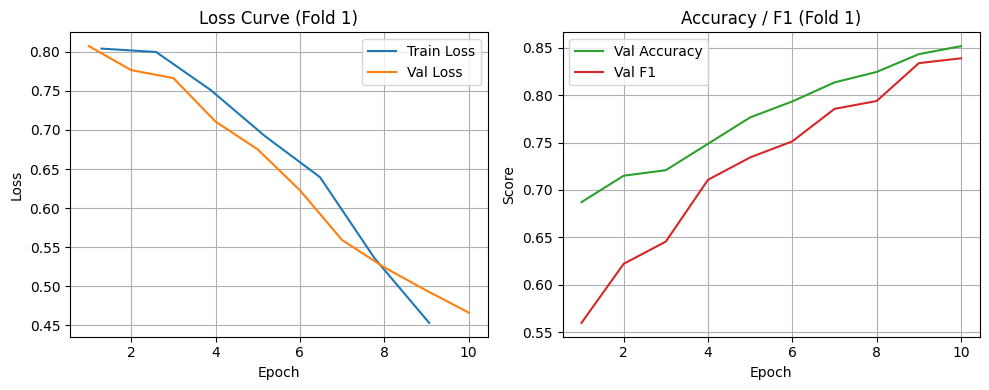

Fold 1 Weighted F1 Score: 0.8389


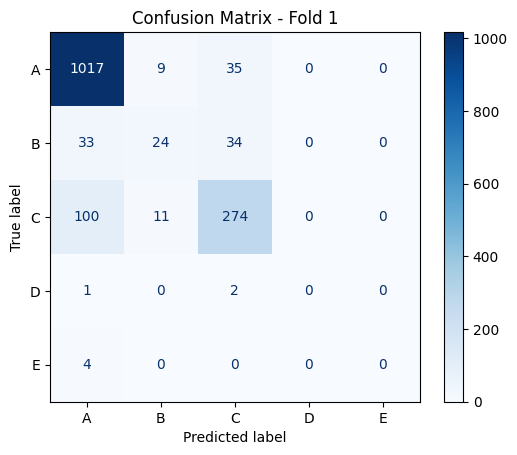

[Fold 2 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_42832\2519183159.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.806428,0.687622,0.560343
2,0.811000,0.795720,0.687622,0.560343
3,0.802800,0.800717,0.687622,0.560343
4,0.802600,0.795358,0.687622,0.560343
5,0.802600,0.801361,0.687622,0.560343
6,0.797300,0.793881,0.687622,0.560343
7,0.795900,0.716622,0.741413,0.690237
8,0.715600,0.645957,0.782242,0.742799
9,0.715600,0.569871,0.807518,0.771271
10,0.612200,0.534553,0.830849,0.799314


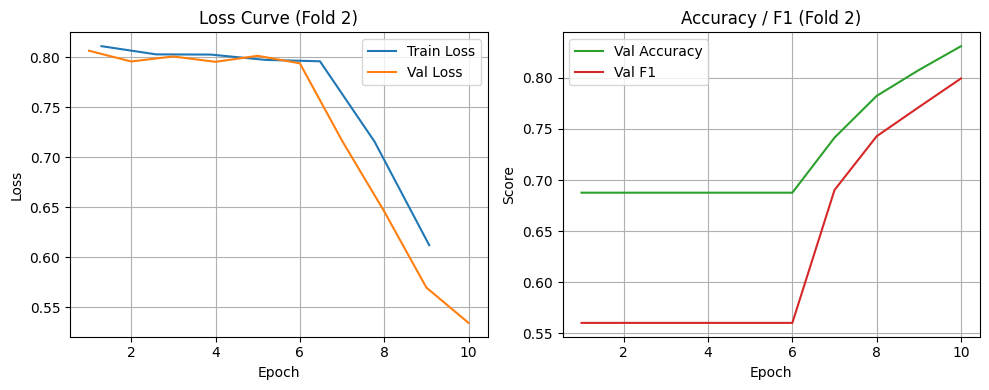

Fold 2 Weighted F1 Score: 0.7993


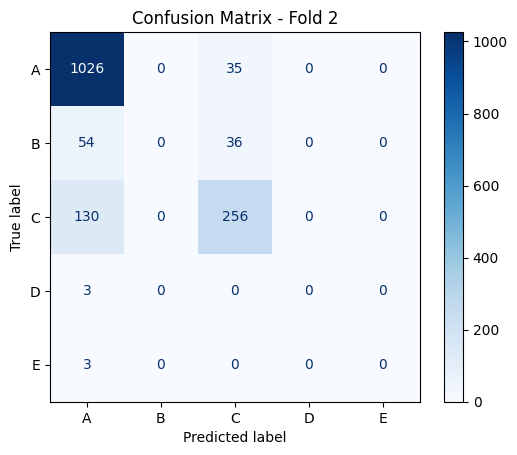

[Fold 3 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_42832\2519183159.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.740935,0.734284,0.679413
2,0.767000,0.542325,0.812703,0.778751
3,0.584400,0.502135,0.830849,0.802692
4,0.449300,0.454799,0.862605,0.841892
5,0.449300,0.387970,0.878159,0.875986
6,0.344100,0.369860,0.900843,0.898504
7,0.242100,0.376641,0.900194,0.895102
8,0.163300,0.339829,0.911212,0.907889
9,0.163300,0.361264,0.915749,0.914411
10,0.109000,0.352952,0.919637,0.918127


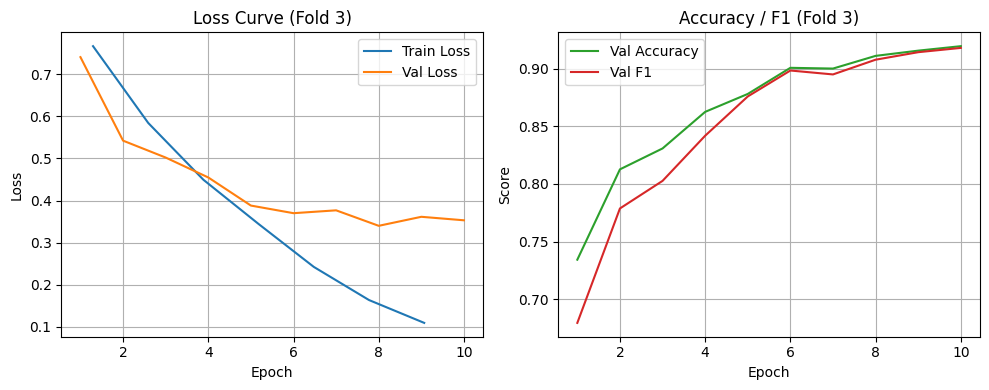

Fold 3 Weighted F1 Score: 0.9181


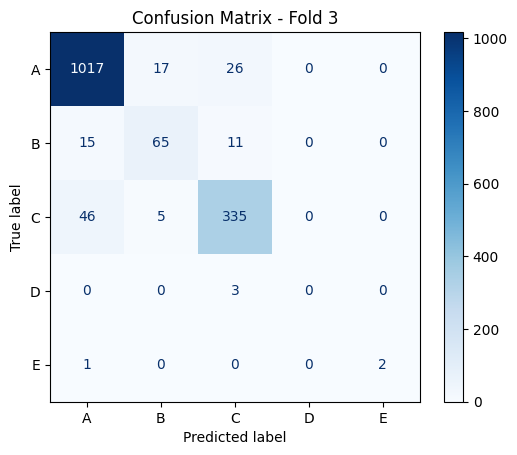

[Fold 4 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_42832\2519183159.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.808221,0.686973,0.559502
2,0.814400,0.796945,0.686973,0.559502
3,0.801700,0.769642,0.712897,0.653956
4,0.800700,0.796735,0.686973,0.559502
5,0.800700,0.802887,0.686973,0.559502
6,0.797100,0.796943,0.686973,0.559502
7,0.801300,0.796113,0.686973,0.559502
8,0.794200,0.794838,0.686973,0.559502
9,0.794200,0.782637,0.692158,0.670111
10,0.767000,0.710518,0.751134,0.701911


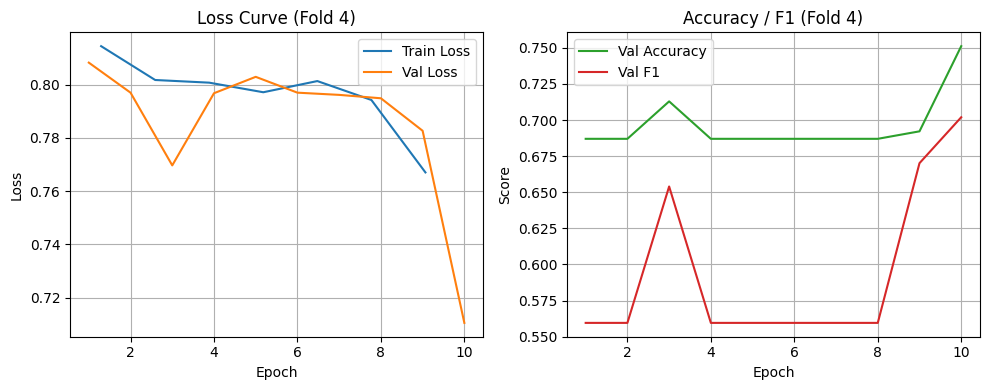

Fold 4 Weighted F1 Score: 0.7019


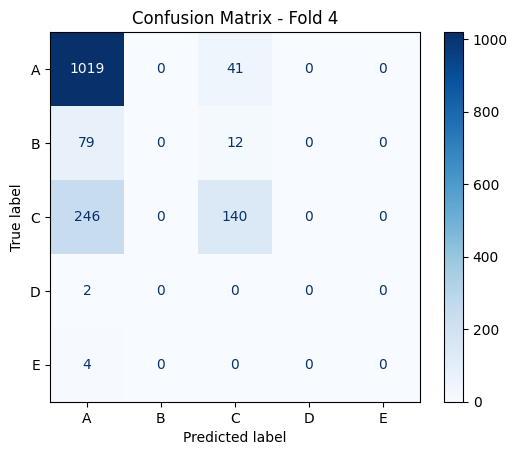

[Fold 5 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_42832\2519183159.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.801656,0.686973,0.559502
2,0.807700,0.796860,0.686973,0.559502
3,0.801100,0.811044,0.680493,0.571455
4,0.799700,0.790983,0.692158,0.571386
5,0.799700,0.758050,0.709008,0.675784
6,0.773800,0.712460,0.748542,0.692125
7,0.717900,0.659637,0.782242,0.740510
8,0.633300,0.614250,0.791316,0.750059
9,0.633300,0.576012,0.810758,0.777033
10,0.569000,0.554899,0.822424,0.789013


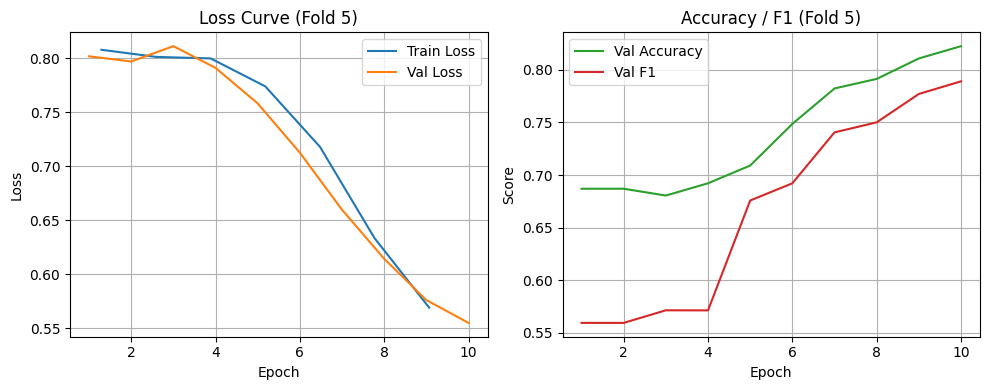

Fold 5 Weighted F1 Score: 0.7890


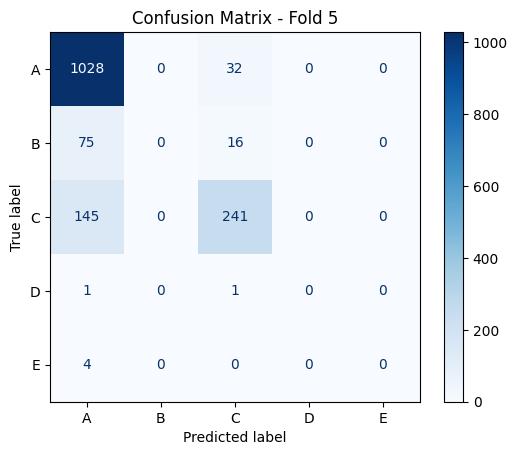

In [5]:
BATCH_SIZE = 16
EPOCHS = 10
LR = 5e-4

all_f1_scores, all_conf_matrices = [], []
all_train_accs, all_val_accs = [], []
all_train_losses, all_val_losses = [], []
all_train_f1s, all_val_f1s = [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # ======================
    # 4. モデル初期化
    # ======================
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/vit-gpcr-gradation-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-1e-5/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        f1 = f1_score(labels, preds, average="weighted")
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        return {"accuracy": acc, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ======================
    # 7. 推論と評価
    # ======================

    # ---- ログから学習曲線抽出 ----
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    # ---- 保存 ----
    all_train_losses.append(train_loss["loss"].values)
    all_val_losses.append(eval_loss["eval_loss"].values)
    all_train_accs.append(np.interp(train_loss["epoch"], eval_loss["epoch"], eval_loss["eval_accuracy"]))  # 補間
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_train_f1s.append(np.interp(train_loss["epoch"], eval_loss["epoch"], eval_loss["eval_f1"]))
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ---- foldごとの学習曲線を可視化 ----
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val F1", color="C3")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title(f"Accuracy / F1 (Fold {fold+1})")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)
    f1 = f1_score(y_true, y_pred, average="weighted")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))
    all_f1_scores.append(f1)
    all_conf_matrices.append(cm)

    print(f"Fold {fold+1} Weighted F1 Score: \033[32m{f1:.4f}\033[0m")

    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

## 4. 平均可視化

val_losses lengths: [10, 10, 10, 10, 10]
val_accs lengths: [10, 10, 10, 10, 10]
val_f1s lengths: [10, 10, 10, 10, 10]


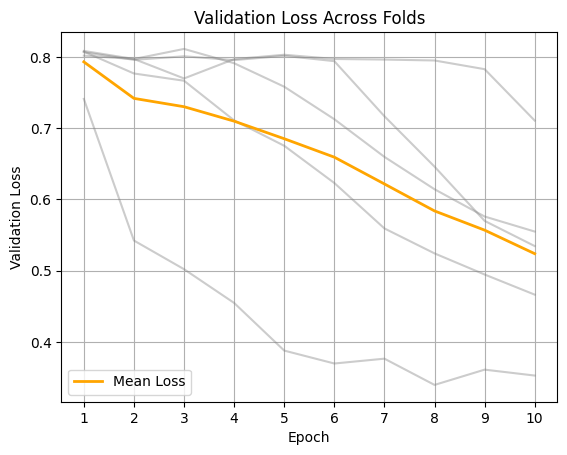

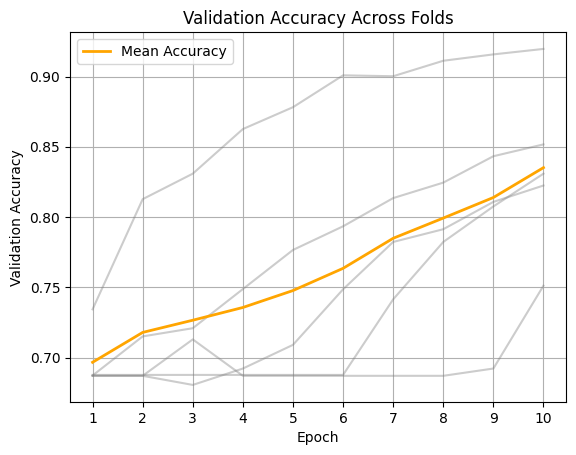

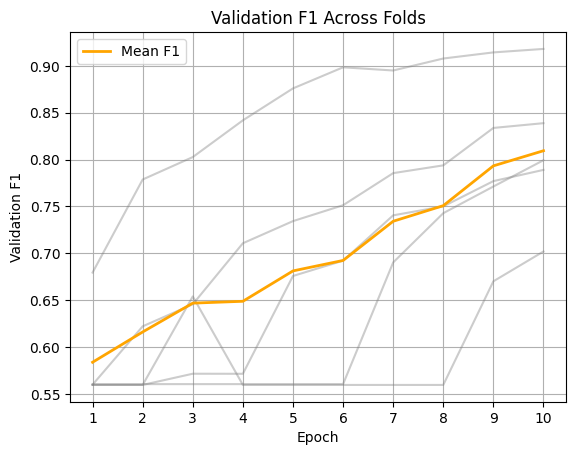

In [6]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for i, v in enumerate(all_vals):
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)
    std_vals = interp_vals.std(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    # plt.fill_between(epochs, mean_vals - std_vals, mean_vals + std_vals, color="orange", alpha=0.15)
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

# --- debug printing to inspect shapes ---
print("val_losses lengths:", [len(x) for x in all_val_losses])
print("val_accs lengths:", [len(x) for x in all_val_accs])
print("val_f1s lengths:", [len(x) for x in all_val_f1s])

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価

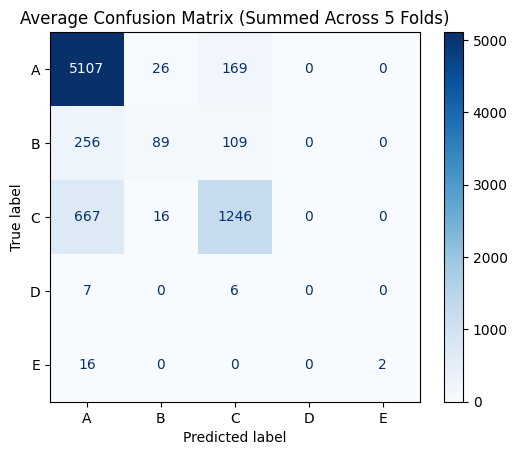


Average Weighted F1 Score: 0.8094487526718546


In [7]:
mean_cm = np.sum(all_conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()

print("\nAverage Weighted F1 Score:", np.mean(all_f1_scores))